<h1 style='text-align: center;'> Facial Emotion Detector </h1>

## Importing Libraries

In [45]:
from IPython import display

In [46]:
!pip install utils livelossplot
display.clear_output()

In [47]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from livelossplot.inputs.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
from IPython.display import SVG, Image

import utils

## Loading Dataset

In [48]:
for expression in os.listdir("dataset/train/"):
    print(str(len(os.listdir("dataset/train/" + expression))) + " " + expression + " images")

7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


## Setting up image data generators for training and validation using Keras

In [49]:
# Configuration
img_size = 48
batch_size = 64

# Define a function to create a data generator
def create_data_generator(directory, batch_size, is_training):
    datagen = ImageDataGenerator(horizontal_flip=is_training)
    shuffle = is_training  # Shuffle data only during training
    color_mode = "grayscale"  # Convert images to grayscale
    class_mode = 'categorical'
    
    return datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle
    )

# Paths to the train and test folders
train_folder_path = "dataset/train/"
test_folder_path = "dataset/test/"

# Create data generators for training and validation
train_generator = create_data_generator(train_folder_path, batch_size, is_training=True)
validation_generator = create_data_generator(test_folder_path, batch_size, is_training=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Create Convolutional Neural Network (CNN) Model using Keras

In [50]:
# Define the CNN model
model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolutional layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolutional layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolutional layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output before the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer with softmax activation for multi-class classification
model.add(Dense(7, activation='softmax'))

# Compile the model
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)      

## Training and Evaluation

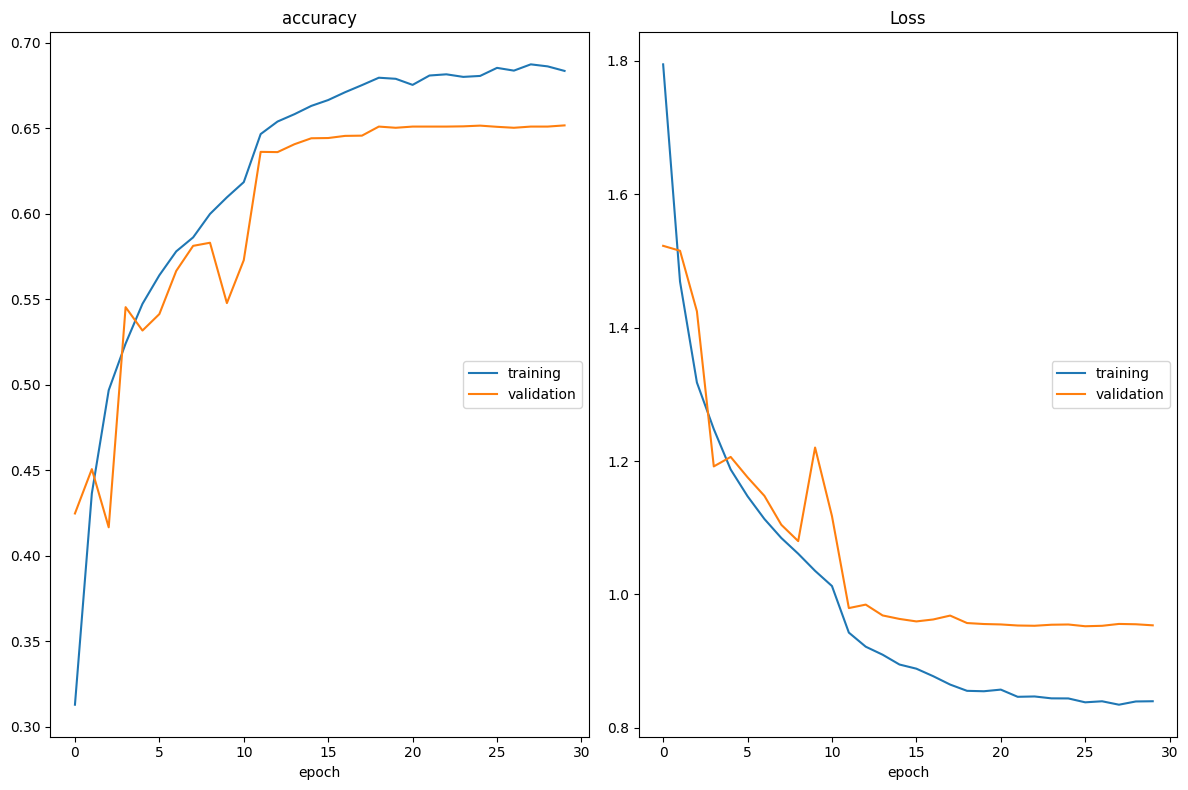

accuracy
	training         	 (min:    0.313, max:    0.687, cur:    0.684)
	validation       	 (min:    0.417, max:    0.652, cur:    0.652)
Loss
	training         	 (min:    0.835, max:    1.795, cur:    0.840)
	validation       	 (min:    0.952, max:    1.523, cur:    0.954)

Epoch 30: saving model to models/emotion_model.h5
448/448 [==============================] - 409s 913ms/step - loss: 0.8399 - accuracy: 0.6835 - val_loss: 0.9537 - val_accuracy: 0.6516 - lr: 1.0000e-05
CPU times: user 21h 45min 26s, sys: 2h 28min 15s, total: 1d 13min 42s
Wall time: 5h 41min 51s


In [51]:
%%time

epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("models/emotion_model.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## Saving the model in json format with its weights 

In [54]:
model_json = model.to_json()
with open("models/emotion_model.json", "w") as json_file:
    json_file.write(model_json)